In [1]:
#import dependencies
import os, urllib, io
from datetime import datetime
import numpy as np

import pandas as pd
import torch, torchvision
from torch import nn, optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
# import the Google Colab GDrive connector
# from google.colab import drive

# mount GDrive inside the Colab notebook
# drive.mount('/content/drive')

# create Colab Notebooks directory
# notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
# if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

# create data sub-directory inside the Colab Notebooks directory
# data_directory = '/content/drive/MyDrive/Colab Notebooks/data_fmnist'
# if not os.path.exists(data_directory): os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
# models_directory = '/content/drive/MyDrive/Colab Notebooks/models_fmnist'
# if not os.path.exists(models_directory): os.makedirs(models_directory)

Mounted at /content/drive


In [ ]:
# create the data sub-directory
data_directory = './data_fmnist'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './models_fmnist'
if not os.path.exists(models_directory): os.makedirs(models_directory)

In [3]:
# initialize the seed
seed = 42
np.random.seed(seed)

In [4]:
# select the device to be used for training
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu').type

# init seed for every device
torch.manual_seed(seed) # cpu
torch.cuda.manual_seed(seed) # gpu
torch.mps.manual_seed(seed) # mps

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [5]:
# specify training path for loading
train_path = data_directory + '/train_fmnist'

In [6]:
# define pytorch transformation into tensor format
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_train_data = torchvision.datasets.FashionMNIST(root=train_path, train=True, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 14987698.66it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 281700.29it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5049968.40it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5335378.55it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/train_fmnist/FashionMNIST/raw



In [7]:
# define fashion mnist classes
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

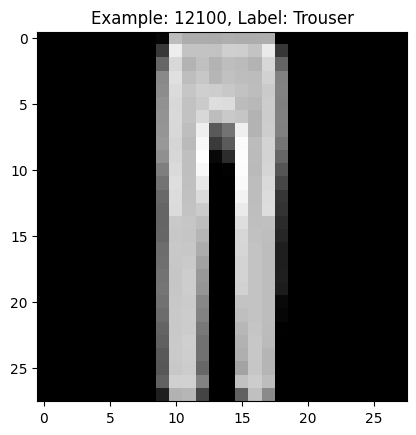

In [8]:
image_id = 12100
fashion_mnist_train_image, fashion_mnist_train_label = fashion_mnist_train_data[image_id]

# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_train_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_train_image), cmap='gray')

In [9]:
fashion_mnist_train_image.size()

torch.Size([1, 28, 28])

In [10]:
eval_path = data_directory + '/eval_fmnist'

# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_eval_data = torchvision.datasets.FashionMNIST(root=eval_path, train=False, transform=transf, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 14929532.47it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 280142.30it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4982265.74it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5793473.84it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/data_fmnist/eval_fmnist/FashionMNIST/raw



In [ ]:
len(fashion_mnist_eval_data)

10000

In [51]:
class FashionMNISTNet(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(FashionMNISTNet, self).__init__()

        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0)

        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify fully-connected (fc) layer 1 - in 12*12*3, out 48
        self.linear1 = nn.Linear(12*12*3, 48, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity

        # specify fc layer 2 - in 48, out 10
        self.linear2 = nn.Linear(48, 10, bias=True) # the linearity W*x+b

        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

    # define network forward pass
    def forward(self, images):
        # high-level feature learning via convolutional layers

        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))

        #print(x.shape)

        # reshape image pixels
        x = x.view(-1, 12*12*3)

        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))

        # define layer 2 forward pass
        x = self.logsoftmax(self.linear2(x))

        # return forward pass result
        return x

In [52]:
model = FashionMNISTNet()
model = model.to(device)

In [53]:
# print the initialized architectures
print('[LOG] FashionMNISTNet architecture:\n\n{}\n'.format(model))

[LOG] FashionMNISTNet architecture:

FashionMNISTNet(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=432, out_features=48, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=48, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



In [54]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()

# print the number of model paramters
print('[LOG] Number of to be trained FashionMNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained FashionMNISTNet model parameters: 21352.


In [55]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()
nll_loss = nll_loss.to(device)

In [56]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

In [57]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

In [58]:
fashion_mnist_train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train_data, batch_size=mini_batch_size, shuffle=True)

In [59]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the FashionMNISTNet model
for epoch in range(num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(fashion_mnist_train_dataloader):

          # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = model(images)

        # reset graph gradients
        model.zero_grad()

        # determine classification loss
        loss = nll_loss(output, labels)

        # run backward pass
        loss.backward()

        # update network parameters
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # set filename of actual model
    model_name = 'FashionMNIST10_model_epoch_{}.pth'.format(str(epoch))

    # save model to local directory
    torch.save(model.state_dict(), os.path.join(models_directory, model_name))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20230612-10:48:06] epoch: 0 train-loss: 2.2526480139954
[LOG 20230612-10:48:15] epoch: 1 train-loss: 2.099825221338252
[LOG 20230612-10:48:24] epoch: 2 train-loss: 1.7643840046071295
[LOG 20230612-10:48:34] epoch: 3 train-loss: 1.3442011250615882
[LOG 20230612-10:48:43] epoch: 4 train-loss: 1.0936572580957717
[LOG 20230612-10:48:52] epoch: 5 train-loss: 0.9689054789065298
[LOG 20230612-10:49:01] epoch: 6 train-loss: 0.8954697060686693
[LOG 20230612-10:49:10] epoch: 7 train-loss: 0.8458735344252353
[LOG 20230612-10:49:19] epoch: 8 train-loss: 0.8092295157629797
[LOG 20230612-10:49:27] epoch: 9 train-loss: 0.7805245467848869
[LOG 20230612-10:49:36] epoch: 10 train-loss: 0.7563936643000605
[LOG 20230612-10:49:45] epoch: 11 train-loss: 0.736265285437041
[LOG 20230612-10:49:54] epoch: 12 train-loss: 0.7186596506694233
[LOG 20230612-10:50:04] epoch: 13 train-loss: 0.7027509830780884
[LOG 20230612-10:50:12] epoch: 14 train-loss: 0.6884405700636825
[LOG 20230612-10:50:21] epoch: 15 train-